## Musical Instrument Chord Classification

#### Imports

In [93]:
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import pandas as pd
import os
import numpy as np
import seaborn as sns
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.optimizers import Adam
from sklearn import metrics
from keras.callbacks import ModelCheckpoint
from datetime import datetime 
from keras import datasets, layers, models

#### Data Preparation

In [44]:
import librosa
audio_file_path='../Dataset/audio/Major/Major_4.wav'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

In [45]:
librosa_audio_data

array([-0.00360439, -0.00573094, -0.0050764 , ...,  0.        ,
       -0.        ,  0.        ], dtype=float32)

In [46]:
librosa_sample_rate

22050

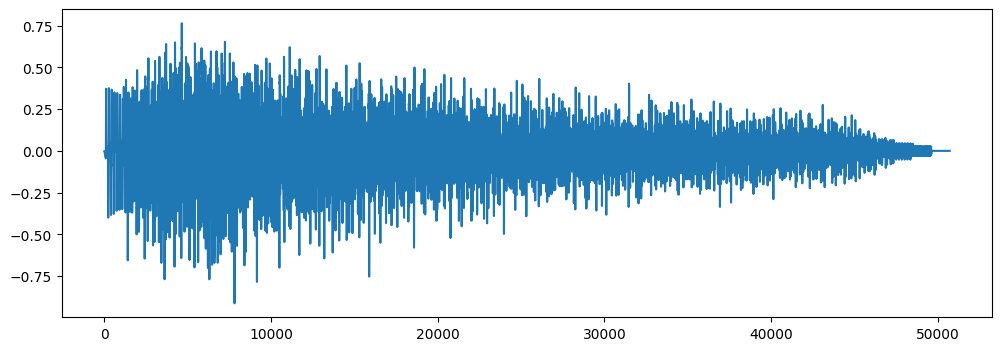

In [48]:
# Original audio with 1 channel 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

In [50]:
wave_sample_rate, wave_audio = wav.read(audio_file_path) 

In [51]:
wave_audio

array([-142, -193, -158, ...,    0,    0,    0], dtype=int16)

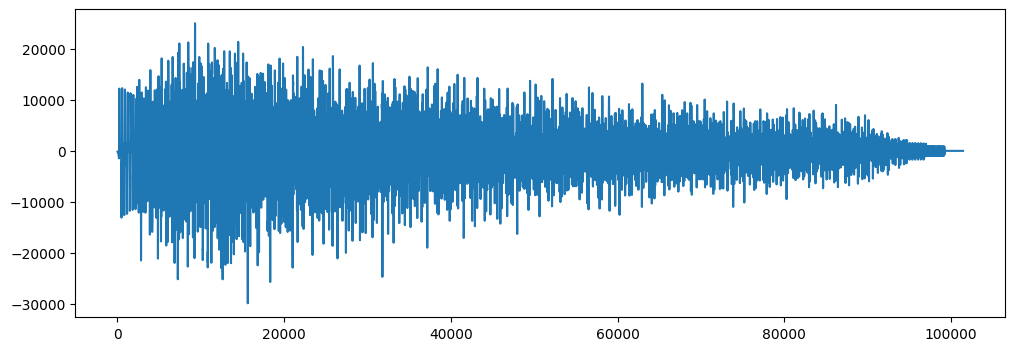

In [52]:
# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

In [61]:
data_dir = '../Dataset/audio'

file_paths = []
labels = []

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for file_name in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file_name)
            file_paths.append(file_path)
            labels.append(label)

df = pd.DataFrame({'file_path': file_paths, 'label': labels})

In [62]:
df.head()

,file_path,label
0,../Dataset/audio/Major/Major_500.wav,Major
1,../Dataset/audio/Major/Major_266.wav,Major
2,../Dataset/audio/Major/Major_272.wav,Major
3,../Dataset/audio/Major/Major_299.wav,Major
4,../Dataset/audio/Major/Major_474.wav,Major


In [92]:
# count the number of samples for each label
df['label'].value_counts()

Major    502
Minor    357
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

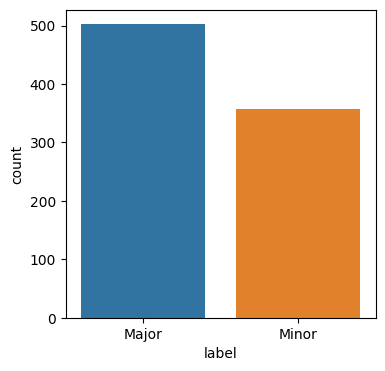

In [65]:
# countplot of labels with counts
plt.figure(figsize=(4, 4))
sns.countplot(x='label', data=df)

#### Feature Extraction

Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [53]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 100)


In [54]:
mfccs

array([[-3.21483673e+02, -3.02592743e+02, -2.51817734e+02, ...,
        -4.01579620e+02, -4.88464569e+02, -6.33760742e+02],
       [ 2.69293976e+02,  2.71705231e+02,  2.74144165e+02, ...,
         1.25161591e+02,  1.15193275e+02,  0.00000000e+00],
       [ 2.40720940e+01,  8.46327496e+00, -1.82076969e+01, ...,
         3.89744854e+00,  1.01470566e+01,  0.00000000e+00],
       ...,
       [-1.39344013e+00, -4.51191854e+00, -5.17483997e+00, ...,
         5.48824596e+00,  2.36826587e+00,  0.00000000e+00],
       [-1.15002174e+01, -1.22891912e+01, -1.41595516e+01, ...,
         4.29746056e+00,  5.32274723e-01,  0.00000000e+00],
       [-1.92314072e+01, -1.58172750e+01, -5.91461372e+00, ...,
         3.72530890e+00,  5.37545443e-01,  0.00000000e+00]], dtype=float32)

In [66]:
def extract_features(audio_path, duration=2, sr=22050, n_mfcc=20):
    # Load the audio file
    audio, _ = librosa.load(audio_path, sr=sr, duration=duration)

    # Extract features using MFCC
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    # Concatenate the mean and standard deviation features
    features = np.concatenate((mfcc_mean, mfcc_std))

    return features
    

In [67]:
def preprocess_data(data_directory):
    # Initialize empty lists for features and labels
    features = []
    labels = []

    # Iterate through the class label directories
    for class_label in os.listdir(data_directory):
        class_directory = os.path.join(data_directory, class_label)

        # Iterate through the audio files in the class label directory
        for audio_file in os.listdir(class_directory):
            audio_path = os.path.join(class_directory, audio_file)

            # Extract features from the audio file
            audio_features = extract_features(audio_path)

            # Append the features and corresponding label to the lists
            features.append(audio_features)
            labels.append(class_label)

    # Convert the lists to NumPy arrays
    features = np.array(features)
    labels = np.array(labels)

    return features, labels

In [69]:
data_directory = "../Dataset/audio/"
features, labels = preprocess_data(data_directory)

features.shape

(859, 40)

In [70]:
labels.shape

(859,)

In [72]:
features[0]

array([-279.828     ,  233.99982   ,    3.321904  ,   -5.1202745 ,
          3.202868  ,   -9.905617  ,  -17.318272  ,  -11.688515  ,
         -8.416153  ,  -28.100437  ,  -36.09749   ,  -17.67861   ,
         -3.9105055 ,   -1.7331359 ,  -12.595881  ,  -16.962742  ,
         -6.684754  ,   -4.6976585 ,   -7.7623024 ,   -0.80477166,
         74.960815  ,   27.964481  ,   21.77986   ,   10.364605  ,
         10.319472  ,    7.571707  ,    8.069125  ,    6.341401  ,
          7.789077  ,    7.64261   ,    9.114444  ,    5.3278003 ,
          3.1090086 ,    2.144262  ,    3.201752  ,    4.569781  ,
          3.071208  ,    3.2190907 ,    3.1577435 ,    2.8051069 ],
      dtype=float32)

In [73]:
# convert the features and corresponding labels to df
features_df = pd.DataFrame({'features': list(features), 'labels': labels})

In [74]:
features_df.head()

,features,labels
0,"[-279.828, 233.99982, 3.321904, -5.1202745, 3....",Major
1,"[-241.15944, 236.79521, -7.730321, -4.8120694,...",Major
2,"[-250.74883, 240.53954, -6.1479445, -1.3055583...",Major
3,"[-379.5301, 188.1612, 41.60088, 10.753425, 5.2...",Major
4,"[-277.15405, 248.01863, 2.0289304, -0.9230715,...",Major


In [75]:
### Split the dataset into independent and dependent dataset
X=np.array(features_df['features'].tolist())
y=np.array(features_df['labels'].tolist())

In [76]:
# shape of independent and dependent dataset
X.shape, y.shape

((859, 40), (859,))

In [78]:
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [79]:
y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [81]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [82]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((687, 40), (172, 40), (687, 2), (172, 2))

In [84]:
num_labels=y.shape[1]

#### Approach 1: ANN

In [98]:
ann = models.Sequential([
    layers.Flatten(input_shape=(40,)),
    layers.Dense(3000, activation='relu'),
    layers.Dense(1000, activation='relu'),
    layers.Dense(num_labels, activation='softmax')
])

In [99]:
ann.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 40)                0         
                                                                 
 dense_19 (Dense)            (None, 3000)              123000    
                                                                 
 dense_20 (Dense)            (None, 1000)              3001000   
                                                                 
 dense_21 (Dense)            (None, 2)                 2002      
                                                                 
Total params: 3126002 (11.92 MB)
Trainable params: 3126002 (11.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [100]:
ann.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [101]:
num_epochs = 100
num_batch_size = 32

# checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
#                                verbose=1, save_best_only=True)

start = datetime.now()

ann.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
 1/22 [>.............................] - ETA: 7s - loss: 6.0198 - accuracy: 0.2812

2023-07-05 20:52:20.771176: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-05 20:52:20.777412: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


22/22 [==============================] - 1s 23ms/step - loss: 29.1729 - accuracy: 0.5415 - val_loss: 6.2001 - val_accuracy: 0.4070
Epoch 2/100
11/22 [==============>...............] - ETA: 0s - loss: 2.5719 - accuracy: 0.5341

2023-07-05 20:52:21.374140: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-05 20:52:21.377377: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


22/22 [==============================] - 0s 13ms/step - loss: 1.7484 - accuracy: 0.5211 - val_loss: 0.7113 - val_accuracy: 0.5523
Epoch 3/100
22/22 [==============================] - 0s 12ms/step - loss: 0.7748 - accuracy: 0.5488 - val_loss: 0.7386 - val_accuracy: 0.4360
Epoch 4/100
22/22 [==============================] - 0s 13ms/step - loss: 0.7097 - accuracy: 0.5662 - val_loss: 0.6931 - val_accuracy: 0.5581
Epoch 5/100
22/22 [==============================] - 0s 12ms/step - loss: 0.7934 - accuracy: 0.5502 - val_loss: 0.8143 - val_accuracy: 0.4535
Epoch 6/100
22/22 [==============================] - 0s 13ms/step - loss: 0.7702 - accuracy: 0.5560 - val_loss: 0.8573 - val_accuracy: 0.5930
Epoch 7/100
22/22 [==============================] - 0s 12ms/step - loss: 0.7088 - accuracy: 0.5764 - val_loss: 0.7149 - val_accuracy: 0.5058
Epoch 8/100
22/22 [==============================] - 0s 13ms/step - loss: 0.7639 - accuracy: 0.5721 - val_loss: 0.6896 - val_accuracy: 0.6337
Epoch 9/100
22/22 

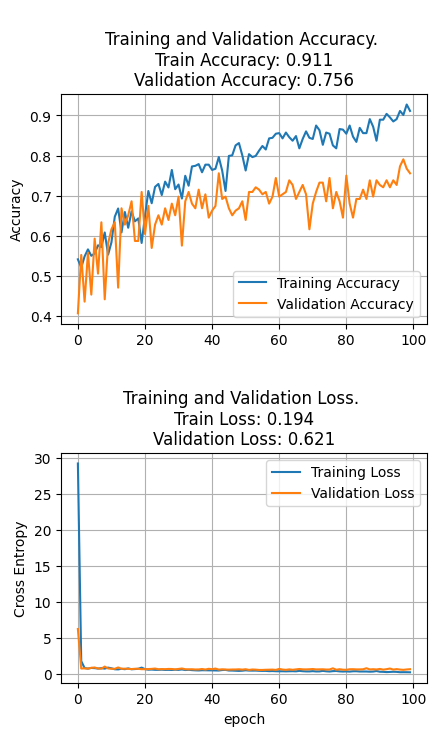

In [102]:
plot_history(ann.history)

#### Approach 2: CNN

In [103]:
model=Sequential()
###first layer
model.add(Dense(1000,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(2000))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [104]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 1000)              41000     
                                                                 
 activation_4 (Activation)   (None, 1000)              0         
                                                                 
 dropout_11 (Dropout)        (None, 1000)              0         
                                                                 
 dense_23 (Dense)            (None, 2000)              2002000   
                                                                 
 activation_5 (Activation)   (None, 2000)              0         
                                                                 
 dropout_12 (Dropout)        (None, 2000)              0         
                                                                 
 dense_24 (Dense)            (None, 1000)             

In [105]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [106]:
num_epochs = 100
num_batch_size = 32

# checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
#                                verbose=1, save_best_only=True)

start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
 5/22 [=====>........................] - ETA: 0s - loss: 46.1432 - accuracy: 0.4375

2023-07-05 20:58:49.650505: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-05 20:58:49.659783: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


22/22 [==============================] - 1s 24ms/step - loss: 22.4652 - accuracy: 0.4934 - val_loss: 2.6535 - val_accuracy: 0.4070
Epoch 2/100
 5/22 [=====>........................] - ETA: 0s - loss: 4.4583 - accuracy: 0.4875

2023-07-05 20:58:50.192951: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-05 20:58:50.196489: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


22/22 [==============================] - 0s 16ms/step - loss: 2.8658 - accuracy: 0.5022 - val_loss: 0.7133 - val_accuracy: 0.5174
Epoch 3/100
22/22 [==============================] - 0s 15ms/step - loss: 1.6235 - accuracy: 0.5473 - val_loss: 1.1653 - val_accuracy: 0.4070
Epoch 4/100
22/22 [==============================] - 0s 14ms/step - loss: 1.0620 - accuracy: 0.5138 - val_loss: 0.7916 - val_accuracy: 0.4070
Epoch 5/100
22/22 [==============================] - 0s 15ms/step - loss: 0.8789 - accuracy: 0.5313 - val_loss: 0.7732 - val_accuracy: 0.4070
Epoch 6/100
22/22 [==============================] - 0s 15ms/step - loss: 0.8325 - accuracy: 0.5488 - val_loss: 0.6998 - val_accuracy: 0.4535
Epoch 7/100
22/22 [==============================] - 0s 15ms/step - loss: 0.8092 - accuracy: 0.5386 - val_loss: 0.6896 - val_accuracy: 0.5465
Epoch 8/100
22/22 [==============================] - 0s 15ms/step - loss: 0.7618 - accuracy: 0.5488 - val_loss: 0.7049 - val_accuracy: 0.4302
Epoch 9/100
22/22 

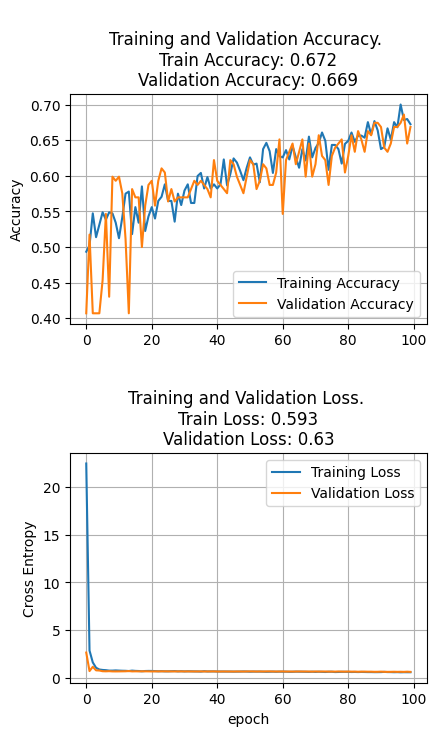

In [107]:
plot_history(model.history)

__________

#### Approach 3: MLP

In [115]:
model = Sequential([
    layers.Dense(64, activation='relu', input_dim=40),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [116]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [118]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
22/22 [==============================] - 0s 9ms/step - loss: 0.6829 - accuracy: 0.6405 - val_loss: 0.7837 - val_accuracy: 0.4942
Epoch 2/100
22/22 [==============================] - 0s 7ms/step - loss: 0.8068 - accuracy: 0.5808 - val_loss: 0.7232 - val_accuracy: 0.6279
Epoch 3/100
22/22 [==============================] - 0s 8ms/step - loss: 0.7443 - accuracy: 0.6070 - val_loss: 0.9983 - val_accuracy: 0.5988
Epoch 4/100
22/22 [==============================] - 0s 8ms/step - loss: 0.7564 - accuracy: 0.5764 - val_loss: 0.8985 - val_accuracy: 0.6047
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 0.6991 - accuracy: 0.6361 - val_loss: 0.7581 - val_accuracy: 0.6453
Epoch 6/100
22/22 [==============================] - 0s 8ms/step - loss: 0.6749 - accuracy: 0.6288 - val_loss: 0.7239 - val_accuracy: 0.5814
Epoch 7/100
22/22 [==============================] - 0s 8ms/step - loss: 0.7539 - accuracy: 0.6012 - val_loss: 0.8279 - val_accuracy: 0.5988
Epoch 8/100
2

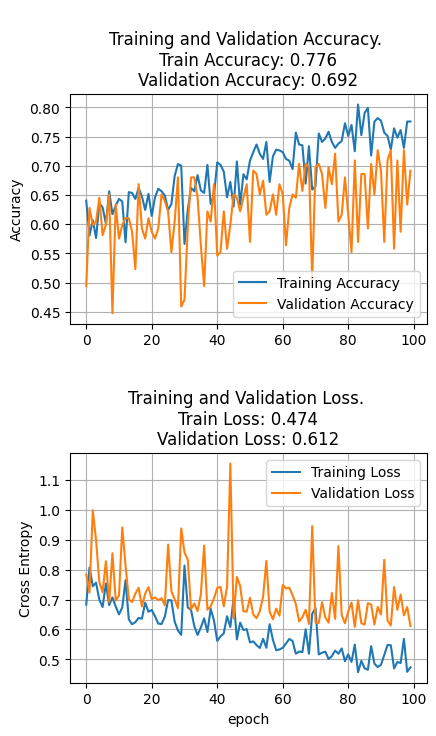

In [119]:
plot_history(model.history)